In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels import api
from scipy import stats
from scipy.optimize import minimize 

In [18]:
# generate an independent variable 
x = np.linspace(-10, 30, 100)
# generate a normally distributed residual
e = np.random.normal(10, 5, 100)
t = np.repeat([1,0],50)
extranoise = t * np.random.normal(30, 20, 100)  
# generate ground truth
y = 10 + 4*x + e + extranoise
df = pd.DataFrame({'x':x, 'y':y, 't':t})
df.head() 

,x,y,t
0,-10.000000,-7.884858,1
1,-9.595960,15.241679,1
2,-9.191919,-4.307988,1
3,-8.787879,3.981640,1
4,-8.383838,27.581406,1


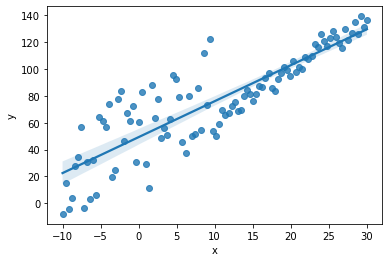

In [22]:
sns.regplot(x='x', y='y', data = df)
plt.show() 

In [20]:
features = api.add_constant(df.x)
model = api.OLS(y, features).fit()
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     295.1
Date:                Thu, 27 Jan 2022   Prob (F-statistic):           2.55e-31
Time:                        11:11:27   Log-Likelihood:                -430.91
No. Observations:                 100   AIC:                             865.8
Df Residuals:                      98   BIC:                             871.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.2914      2.395     20.585      0.000      44.539      54.043
x              2.6774      0.156     17.178      0.000       2.368       2.987
==============================================================================
Omnibus:                        3.058   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.818
Skew:                           0.411   Prob(JB):                        0.244
Kurtosis:                       2.971   Cond. No.                         20.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
res = model.resid
standard_dev = np.std(res)
standard_dev 

17.995862067625694

In [26]:
# MLE function
# ml modeling and neg LL calculation
def MLE_Norm(parameters):
    # extract parameters
    const, beta, noise, std_dev = parameters
    # predict the output
    pred = const + beta*x + t*noise
    # Calculate the log-likelihood for normal distribution
    LL = np.sum(stats.norm.logpdf(y, pred, std_dev))
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL 

In [27]:
# minimize arguments: function, intial_guess_of_parameters, method
mle_model = minimize(MLE_Norm, np.array([2,2,2,2]), method='L-BFGS-B')
mle_model 

      fun: 425.0586301372259
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.68434142e-06, -3.24007489e-04,  0.00000000e+00, -3.41060485e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 29
     njev: 33
   status: 0
  success: True
        x: array([28.44891572,  3.56555995, 23.92152501, 16.97335587])

In [30]:
df = pd.read_csv('results/simdata.csv')

df.head()

,Unnamed: 0,sub,choices,values,risk,ambiguity,riskTol,ambTol
0,0,1,0,5,0.25,0.0,0.640342,1.567908
1,1,1,0,5,0.25,0.0,0.640342,1.567908
2,2,1,0,5,0.25,0.0,0.640342,1.567908
3,3,1,0,5,0.50,0.0,0.640342,1.567908
4,4,1,0,5,0.50,0.0,0.640342,1.567908


In [32]:
df10 = df[df['sub']==1]
df10r = df10[df10['ambiguity']==0]

In [86]:
def MLE_riskamb(parameters):
    # extract parameters
    α, β, γ = parameters
    # predict the output
    
    svLotto = (df10['values'] ** α) * (df10['risk']-(β * (df10['ambiguity']/2)))
    svRef = 5 ** α
    p = 1/(1+np.exp((svRef - svLotto)*γ))
    size = len(p)
    mu = np.random.binomial(1,p,size)

    
    # Calculate the log-likelihood for normal distribution
    LL = np.sum(stats.norm.logpdf(df10.choices, mu))
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL 

In [87]:
mle_model = minimize(MLE_riskamb, np.array([1,0,1]), method='L-BFGS-B')
mle_model 

      fun: 96.19083678919246
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.00000003e+07, -4.00000000e+08, -3.50000002e+08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 2
     njev: 18
   status: 0
  success: True
        x: array([ 1.00000016e+00, -1.59777342e-07,  1.00000074e+00])

In [75]:
df10.choices)

0     0
1     0
2     0
3     0
4     0
     ..
79    0
80    0
81    0
82    0
83    0
Name: choices, Length: 84, dtype: int64

In [39]:
5 ** df10['riskTol'][0]

2.8027207279585706

In [54]:
svLotto = (df10['values'][0] ** df10['riskTol'][0]) * (df10['risk'][0]-(df10['ambTol'][0] * (df10['ambiguity'][0]/2)))
svRef = 5 ** df10['riskTol'][0]
p = 1/np.exp(svRef- svLotto)
np.random.binomial(1,p,1)

array([0])